# Sales Forecasting Using Holt-Winters Method

Replication code for the document “`WOUF: Supply Chain Optimization`”, part of the Final Thesis Project for the Master’s in Operations Management and SCM in EADA Business School.

+ Authors: Boronat, M, Dulanto, H. M., Gálvez, M. A., Ramirez, C. C., and Riaño, A.
+ Code: [Renato Vassallo](https://www.linkedin.com/in/renatovassallo/).

This version: July 2024.

In this project, we use time series techniques to model and forecast the demand for various products of a fashion industry company. The `Holt-Winters Method` is particularly useful for capturing seasonality and trends in sales data, providing accurate predictions that can inform inventory and marketing strategies.

### Pseudo out-of-sample forecasting

To evaluate the predictive accuracy of the model, we use a pseudo out-of-sample forecast strategy. We have weekly sales data from 2018 to 2024. We follow these steps:

1.	Use data from 2018 to 2021 to train the model.
2.	Make forecasts for 2022.
3.	Compare the forecasts for 2022 with the actual sales data from 2022 to evaluate the model.
4.	Then, use data up to 2022 to make forecasts for 2023 and continue the evaluation process.

## 1. Control Panel

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Main definitions
input_file_name = 'wouf_data_2018_2024_v2.xlsx'
last_year_available = 2024
last_week_available = 21
products = ['sleeves_13', 'toiletry_bag', 'small_pouch', 'makeup_bag', 'notebook_a5', 'pencil_case']

# Set te starting points for the forecasts
years = [2020, 2021, 2022, 2023]
start_week = 49 # last week of november, start forecast from 50 onwards

## 2. Load WOUF data

In [5]:
# Load raw data
df_raw = pd.read_excel(f'input/{input_file_name}')

# Filtrar el DataFrame hasta la semana 21 de 2024
df_raw['year_week'] = df_raw['year'] * 100 + df_raw['week']
last_year_week = last_year_available * 100 + last_week_available
df_raw = df_raw[df_raw['year_week'] <= last_year_week]
df_raw.drop(columns=['year_week'], inplace=True)

# select specific products and Impute missing values
main_columns = ['year', 'week'] + products
df = df_raw[main_columns].copy()
df.reset_index(drop=True, inplace=True)
print('Missing values report: \n', df.isna().mean())
df

Missing values report: 
 year            0.0
week            0.0
sleeves_13      0.0
toiletry_bag    0.0
small_pouch     0.0
makeup_bag      0.0
notebook_a5     0.0
pencil_case     0.0
dtype: float64


,year,week,sleeves_13,toiletry_bag,small_pouch,makeup_bag,notebook_a5,pencil_case
0,2018,1,276.0,200.0,156.0,171.0,743.0,152.0
1,2018,2,181.0,132.0,228.0,140.0,222.0,116.0
2,2018,3,429.0,658.0,632.0,428.0,612.0,409.0
3,2018,4,410.0,884.0,28.0,220.0,870.0,20.0
4,2018,5,606.0,684.0,590.0,462.0,577.0,134.0
...,...,...,...,...,...,...,...,...
328,2024,17,181.0,173.0,72.0,67.0,62.0,92.0
329,2024,18,86.0,91.0,53.0,51.0,35.0,11.0
330,2024,19,59.0,58.0,73.0,85.0,13.0,11.0
331,2024,20,79.0,93.0,74.0,61.0,12.0,21.0


### Sales: evolution in time

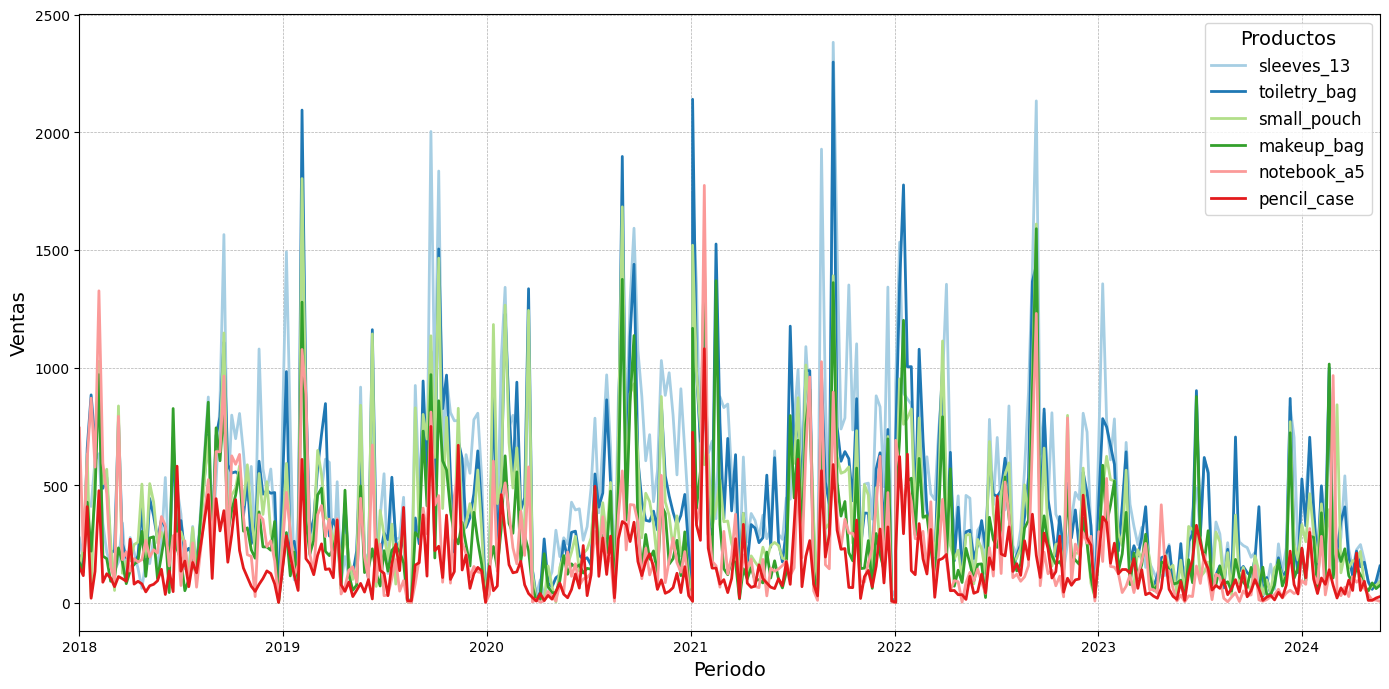

In [14]:
# Convert year and week to a datetime object
df2 = df.copy()
df2['date'] = pd.to_datetime(df2['year'].astype(str) + df2['week'].astype(str).str.zfill(2) + '1', format='%Y%W%w')
df2.set_index('date', inplace=True)
df2.drop(columns=['year', 'week'], inplace=True)

# Plot
plt.figure(figsize=(14, 7))
colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c']  
products = df2.columns

for i, product in enumerate(products):
    plt.plot(df2.index, df2[product], label=product, color=colors[i % len(colors)], linestyle='-', linewidth=2)

plt.xlabel('Periodo', fontsize=14)
plt.ylabel('Ventas', fontsize=14)
plt.legend(title='Productos', fontsize=12, title_fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.xlim(df2.index.min(), df2.index.max())
#plt.savefig('output/figures/products_over_time.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Model main function

In [2]:
def forecast_and_plot(target_var, start_points, figure=True):
    df = pd.read_excel(f'input/{input_file_name}')
    # Function to calculate the next 40 weeks given a start year and week
    def calculate_next_52_weeks(year, week):
        weeks = []
        for i in range(52):
            week += 1
            if week > 52:  # Assuming each year has 52 weeks
                week = 1
                year += 1
            weeks.append((year, week))
        return weeks

    # Initialize the DataFrame for the predictions
    for (year, week) in start_points:
        df[f'forecast_{year}_week_{week}'] = np.nan

    # Perform rolling forecasts from each start point
    for (start_year, start_week) in start_points:
        # Filter data up to the starting point
        mask = (df['year'] < start_year) | ((df['year'] == start_year) & (df['week'] < start_week))
        train_data = df.loc[mask, target_var]

        # Fit the model
        if not train_data.empty:
            model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=52).fit()

            # Calculate next 40 weeks from the starting point
            forecast_weeks = calculate_next_52_weeks(start_year, start_week)
            
            # Forecast the next 40 weeks
            pred = model.forecast(steps=52)

            # Store forecasts in corresponding column
            for (pred_week, pred_value) in zip(forecast_weeks, pred):
                df.loc[(df['year'] == pred_week[0]) & (df['week'] == pred_week[1]), f'forecast_{start_year}_week_{start_week}'] = pred_value

    # Plotting the results
    df['date'] = pd.to_datetime(df['year'].astype(str) + df['week'].astype(str) + '0', format='%Y%W%w')
    df.set_index('date', inplace=True)

    if figure:

        plt.figure(figsize=(14, 7))
        plt.plot(df[target_var], label=f'Actual {target_var}', color='blue')

        # Plot each set of forecasts
        for (year, week) in start_points:
            forecast_label = f'forecast_{year}_week_{week}'
            if forecast_label in df.columns:
                plt.plot(df.index, df[forecast_label], label=f'Forecast {year} w-{week}', linestyle='--', color='red')

        # Set title and labels
        plt.title(f'{target_var} Sales Forecast at Specific Points')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Locate every third month
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))  # Format as 'Month-YY'
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()  # Adjust layout to make room for label rotation
        plt.show()

    return df

## 3. Generating pseudo out-of-sample forecasts

In [17]:
final_forecast = pd.read_excel(f'input/{input_file_name}')
final_forecast = final_forecast[['year', 'week']]
for product in products:
    print(f'forecasting {product}...')
    for year in years:
        start_points = [(year, start_week)] 
        df_forecast = forecast_and_plot(target_var=product, start_points=start_points, figure=False)
        name = f'forecast_{year}_week_{start_week}'
        new_name = f'{product}_{year}'
        df_forecast.rename(columns={name:new_name}, inplace=True)
        sample = df_forecast[['year', 'week', new_name]].reset_index(drop=True)
        final_forecast = final_forecast.merge(sample, on=['year', 'week'], how='left')

# Save output in csv file
final_forecast.to_csv('output/final_forecast.csv', index=False)
final_forecast

forecasting sleeves_13...
forecasting toiletry_bag...
forecasting small_pouch...
forecasting makeup_bag...
forecasting notebook_a5...
forecasting pencil_case...


,year,week,sleeves_13_2020,sleeves_13_2021,sleeves_13_2022,sleeves_13_2023,toiletry_bag_2020,toiletry_bag_2021,toiletry_bag_2022,toiletry_bag_2023,...,makeup_bag_2022,makeup_bag_2023,notebook_a5_2020,notebook_a5_2021,notebook_a5_2022,notebook_a5_2023,pencil_case_2020,pencil_case_2021,pencil_case_2022,pencil_case_2023
0,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,2024,48,NaN,NaN,NaN,203.449089,NaN,NaN,NaN,131.963469,...,NaN,97.070988,NaN,NaN,NaN,32.854092,NaN,NaN,NaN,28.422087
360,2024,49,NaN,NaN,NaN,277.124338,NaN,NaN,NaN,136.673533,...,NaN,11.454201,NaN,NaN,NaN,47.391405,NaN,NaN,NaN,41.087068
361,2024,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362,2024,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Visualizing Real and Forecasted Values

In [6]:
# Load output
final_forecast = pd.read_excel('output/final_forecast.xlsx')
df_forecast = pd.merge(df, final_forecast, how='left', on=['year', 'week'])
df_forecast['date'] = pd.to_datetime(df_forecast['year'].astype(str) + df_forecast['week'].astype(str).str.zfill(2) + '1', format='%Y%W%w')
df_forecast.set_index('date', inplace=True)
df_forecast.drop(columns=['year', 'week'], inplace=True)

# subset between 2021 and 2022
df_forecast = df_forecast['2018-01-01':]
df_forecast

,sleeves_13,toiletry_bag,small_pouch,makeup_bag,notebook_a5,pencil_case,sleeves_13_2020,sleeves_13_2021,sleeves_13_2022,sleeves_13_2023,...,makeup_bag_2022,makeup_bag_2023,notebook_a5_2020,notebook_a5_2021,notebook_a5_2022,notebook_a5_2023,pencil_case_2020,pencil_case_2021,pencil_case_2022,pencil_case_2023
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,276.0,200.0,156.0,171.0,743.0,152.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,181.0,132.0,228.0,140.0,222.0,116.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-15,429.0,658.0,632.0,428.0,612.0,409.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-22,410.0,884.0,28.0,220.0,870.0,20.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-29,606.0,684.0,590.0,462.0,577.0,134.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-22,181.0,173.0,72.0,67.0,62.0,92.0,NaN,NaN,NaN,-196.463589,...,NaN,-93.420327,NaN,NaN,NaN,-127.244502,NaN,NaN,NaN,-42.955823
2024-04-29,86.0,91.0,53.0,51.0,35.0,11.0,NaN,NaN,NaN,-192.019437,...,NaN,-31.227158,NaN,NaN,NaN,-59.381535,NaN,NaN,NaN,-15.199186
2024-05-06,59.0,58.0,73.0,85.0,13.0,11.0,NaN,NaN,NaN,-73.367493,...,NaN,14.000807,NaN,NaN,NaN,-33.606820,NaN,NaN,NaN,-9.588089


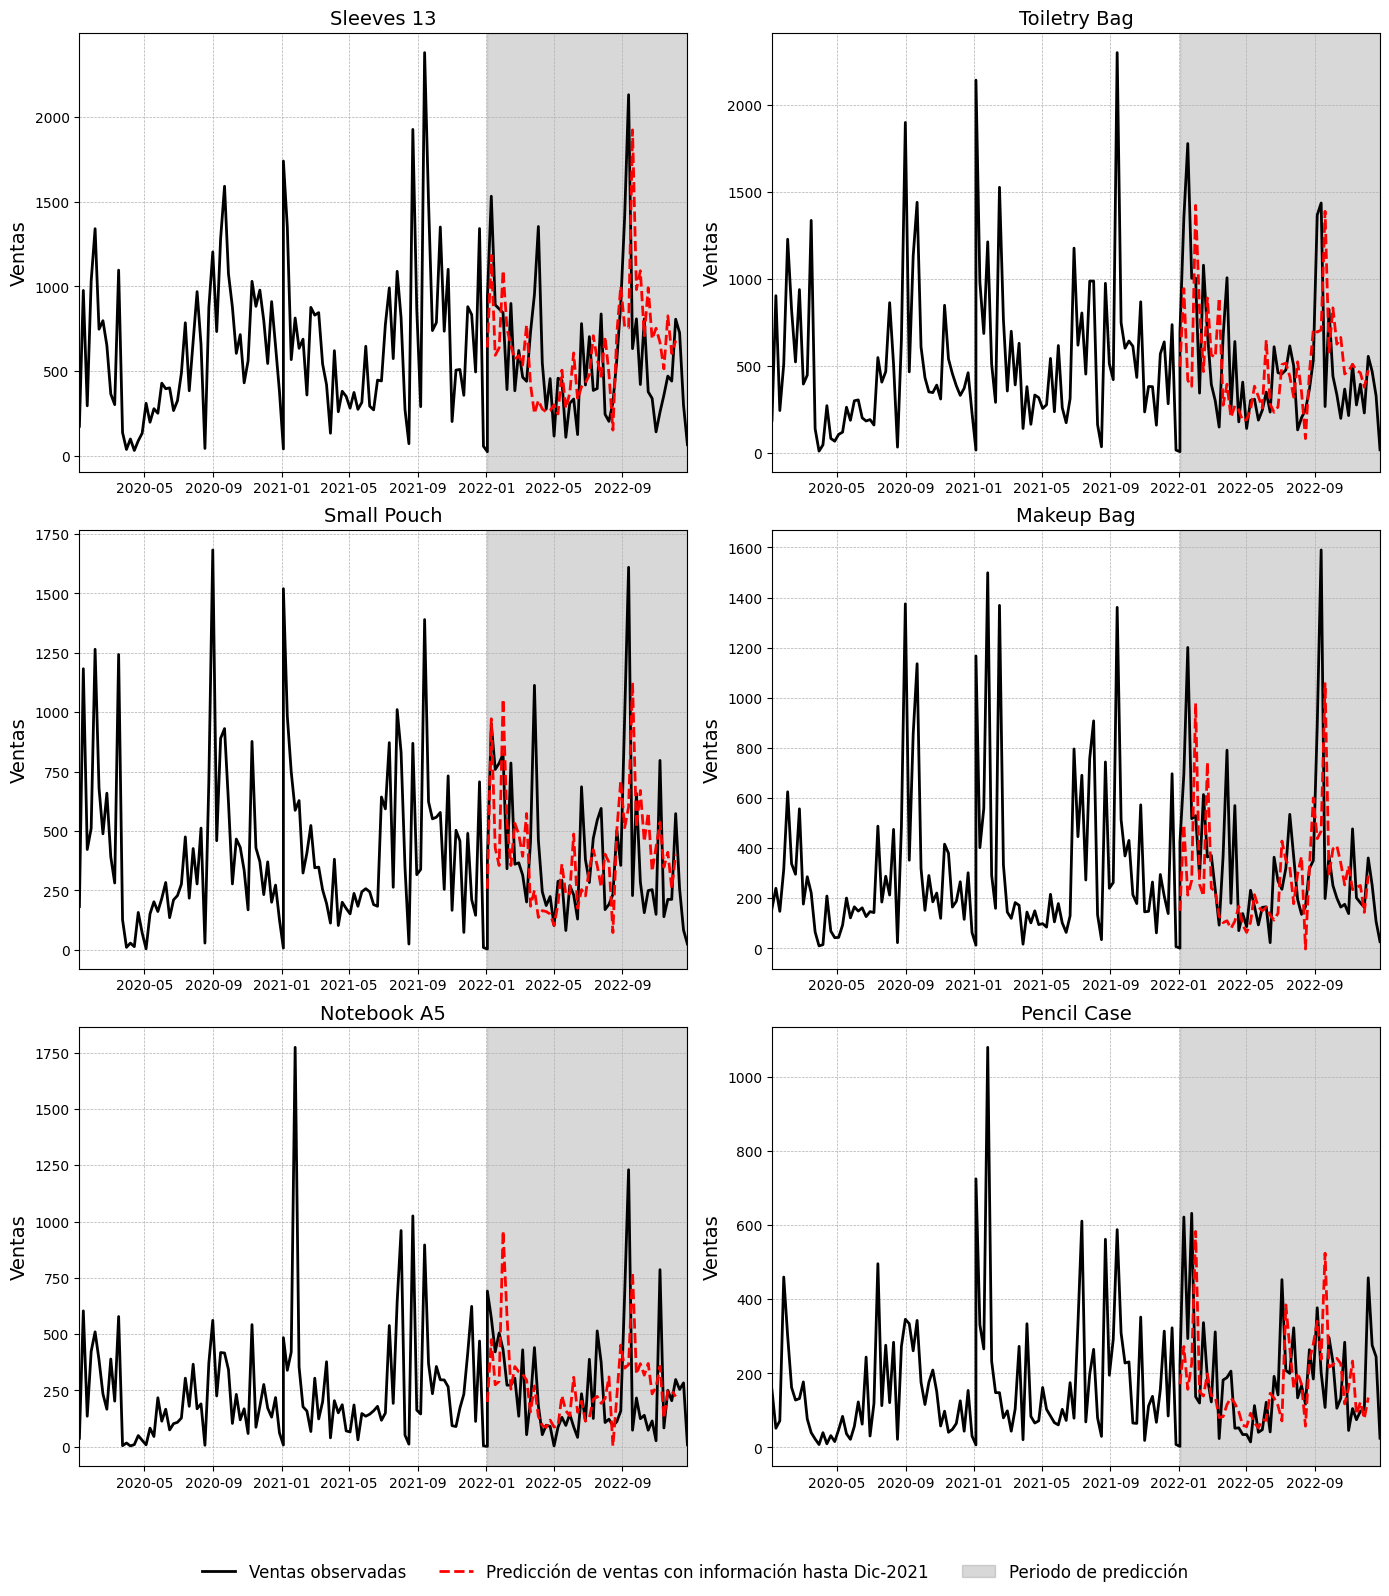

In [8]:
# Filtering the data correctly
historical = df_forecast.loc['2020-01-01':'2022-12-31']
forecast = df_forecast.loc['2022-01-01':'2022-12-31']

# Define the products to plot
products = ['sleeves_13', 'toiletry_bag', 'small_pouch', 'makeup_bag', 'notebook_a5', 'pencil_case']

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(14, 16))

for i, product in enumerate(products):
    row, col = divmod(i, 2)
    forecast_col = product + '_2021'
    axs[row, col].plot(historical.index, historical[product], label='Ventas observadas', color='black', linestyle='-', linewidth=2)
    axs[row, col].plot(forecast.index, forecast[forecast_col], label='Predicción de ventas con información hasta Dic-2021', color='red', linestyle='--', linewidth=2)
    axs[row, col].axvspan(forecast.index.min(), forecast.index.max(), color='grey', alpha=0.3, label='Periodo de predicción')
    axs[row, col].set_ylabel('Ventas', fontsize=14)
    axs[row, col].set_title(product.replace('_', ' ').title(), fontsize=14)
    axs[row, col].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[row, col].set_xlim(historical.index.min(), forecast.index.max())

# Adjust layout
plt.tight_layout()

# Add a common legend below the subplots
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=12, frameon=False)
fig.subplots_adjust(bottom=0.08)  # Adjust the bottom to fit the legend

#plt.savefig('output/figures/forecast_full_2022.pdf', format='pdf', bbox_inches='tight')
plt.show()